In [1]:
#coding: utf-8

# # Here I have combined the three codes from Colm, Irene and Grainne on the text analysis (only - I have not included heat maps yet)
# 
# What I am not clear about is whether we want to include both the weigthed and unweighted bigrams and trigrams? I tried to combine Irene's code and the weighed I used for the bigrams and trigrams. 
# 
# Currently I have also included a small comparison of the weighted and unweighed bigrams (in a not very good fashion). 

'''
To run, make sure the path is correct (fn = 'survey_results_clean.csv')
The easiest way to execute this is probably in a jupyter notebook - some of the plots are not saved to a file
If you get any errors, make sure the column names are the same as in the Midlands survey
'''

# import all of the necessary modules

import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk import ngrams
from nltk import FreqDist
from nltk.collocations import *

from autocorrect import spell
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from PIL import Image
from collections import Counter

import string
import random

## Functions

In [18]:
#Functions from Colm's Code. 

# define a function that will make a wordcloud
# optionally, it can use a masked image to make a particular shape, or use bigrams instead of words
def make_wordcloud(df, column_name, title, output_name, mask = False):
    stop_words = set(stopwords.words('english'))  # these are nonsense words that don't belong in the wordcloud ('a','the' etc.)
    stemmer = SnowballStemmer("english")# this stemmer will clip the end of words so that begins and begin etc. look the same
    
    stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # add some characters to the stopwords
    
    # for every entry in the column, get the list of words and stem them. remove stop words
    word_list = [stemmer.stem(i.lower()) for i in wordpunct_tokenize(" ".join(df[column_name].dropna())) if i.lower() not in stop_words]
    
    # correct any spelling mistakes introduced by the stemmer
    word_list = [spell(i) for i in word_list]
    
    #print(Counter(word_list).most_common(100))
    # if a mask has been provided, use it. Otherwise just make a normal wordcloud
    try:
        np.shape(mask)
        wordcloud = WordCloud(background_color="white", max_words = 200, min_font_size = 10, max_font_size=40, mask = mask).generate(' '.join(word_list))
    except:
        wordcloud = WordCloud(background_color="white", max_words = 100, min_font_size = 10, max_font_size=40).generate(' '.join(word_list))
        
    # now that the wordcloud has been generated, plot it.
    plt.figure() # make a new figure
    plt.imshow(wordcloud) # show the wordcloud
    plt.axis("off") # remove the axes
    plt.title(title) # give it a title
    plt.savefig(output_name, dpi = 300) # optionally, save it to the working directory
    plt.show() # show the image

In [3]:
# Functions from Grainne's code. 

#Function from Colm C. 
def make_tkn_text(df, column_name):
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer("english")
    
    stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])
    
    #remove stop words and punctuation from text. Make into one long string. 
    #reduce words to their 'stem' so we do not get repetitions of same form  i.e. say and saying. 
    word_list = [stemmer.stem(i.lower()) for i in wordpunct_tokenize(" ".join(df[column_name].dropna())) if i.lower() not in stop_words]
    word_list = [spell(i) for i in word_list]
    workable_text = ' '.join(word_list)
        
    tokenized_text = nltk.tokenize.word_tokenize(workable_text)
        
    return tokenized_text

# Ten most common words are found given table and column name. 
def Ten_most_common(table,column_name):
    #Make a full string of text column and split into words
    field_Tkn = make_tkn_text(table,column_name)
    #Find frequency distribution
    fdist_field = FreqDist(field_Tkn)
    #return top 10 words. 
    return fdist_field.most_common(10)


In [4]:
def Field_bigrams(table,column_name,filter_freq,no2return):
    #A pandas dataframe is given with the column name, the filter frequency to be applied to the bigram or trigram, and the number of results to be returned. 
    #The field is converted to a string, and tokenized before being passed ot the bigram fn. 
   
    field_Tkn = make_tkn_text(table,column_name)    
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(field_Tkn)

    #Words can be highly collocated but the expressions are also very infrequent. 
    #Therefore it is useful to apply filters, such as ignoring all bigrams which occur 
    #less than three times in the corpus:
    finder.apply_freq_filter(filter_freq)
    return finder.nbest(bigram_measures.pmi, no2return)


In [5]:
def Field_trigrams(table,column_name,filter_freq, no2return):
    field_Tkn = make_tkn_text(table,column_name)    
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = TrigramCollocationFinder.from_words(field_Tkn)
    
    #A different way to filter the results for how often they occur. 
    #scored = finder.score_ngrams(trigram_measures.raw_freq)
    #set(trigram for trigram, score in scored) == set(nltk.trigrams(field_Tkn))
    #return sorted(finder.nbest(trigram_measures.raw_freq,filter_freq))
    
    finder.apply_freq_filter(filter_freq)
    return finder.nbest(trigram_measures.pmi, no2return)


In [6]:
#Functions from Irene's code. 

def lower_no_stops(all_tokens):
    stop_list = stopwords.words('english') + list(string.punctuation)
    stop_list.append([u'a', u'the'])
    tokens_no_stop = [token.lower() for token in all_tokens
                            if token not in stop_list]
    return tokens_no_stop

def get_ngrams(all_tokens, n=2):
    phrases = ngrams(all_tokens, n)
    
    return phrases

def stem_all(all_tokens):
    stemmer = PorterStemmer()
    all_tokens_lower = [t.lower() for t in all_tokens]

    tokens_normalised = [stemmer.stem(t) for t in all_tokens_lower
                                         if t not in stop_list]
    return tokens_normalised

def get_txt_analysis(strings_of_text):
    all_tokens = [t for t in word_tokenize(strings_of_text)]
    tokens_no_stop = lower_no_stops(all_tokens)
    phrases = get_ngrams(tokens_no_stop, 3)
    
    return phrases

In [7]:
df = pd.read_csv('survey_results_clean.csv', na_values=['nan'])

df['thoughts_facs'] = df['prison_service_facilities_other_thoughts'] + df['improve_contact_family_other_suggestions']



In [8]:
# Weigthed Bigrams and common words. 
common_words = {}
bigrams_phrases = {}
trigrams_phrases = {}

for col in ['sentence_length', 'age', 'prison_wing_main','children']:
    common_temp = {}
    bigrams_temp = {}
    trigrams_temp = {}

    for idx, grp in df.groupby(col):
        field_Tkn = make_tkn_text(grp,'thoughts_facs')    
        
        common_temp[idx]= Counter(field_Tkn).most_common(10)
        bigrams_temp[idx]= Field_bigrams(grp,'thoughts_facs',3,10)
        trigrams_temp[idx]= Field_trigrams(grp,'thoughts_facs',3,10)


    common_words[col] = common_temp
    bigrams_phrases[col] = bigrams_temp
    trigrams_phrases[col] = trigrams_temp

In [9]:
# Unweighted Bigrams. 

sentence_ngrams = {}
stop_list = stopwords.words('english') + list(string.punctuation)
groups = ['prison_service_facilities_other_thoughts', 'improve_contact_family_other_suggestions']

for col in ['sentence_length', 'age', 'prison_wing_main']:
    temp = {}
    for idx, grp in df.groupby(col):
        words1 = grp[pd.notnull(grp['thoughts_facs'])]['thoughts_facs'].tolist()
        w1 = ' '.join(words1)
        all_tokens = [t for t in word_tokenize(w1)]
        tokens_no_stop = lower_no_stops(all_tokens)
        temp[idx]= Counter(ngrams(stem_all(all_tokens), 2)).most_common(5)
    
    sentence_ngrams[col] = temp

## Analysis

In [10]:
pd.DataFrame(common_words['children'])


,No,Yes
0,"(visit, 73)","(visit, 257)"
1,"(time, 24)","(time, 103)"
2,"(privacy, 20)","(phone, 82)"
3,"(longer, 18)","(call, 81)"
4,"(call, 18)","(children, 67)"
5,"(family, 18)","(area, 67)"
6,"(phone, 16)","(longer, 66)"
7,"(enhance, 15)","(family, 66)"
8,"(area, 15)","(enhance, 64)"
9,"(hear, 14)","(box, 54)"


In [11]:
pd.DataFrame(bigrams_phrases['children'])


,No,Yes
0,"(far, away)","(neutral, Venu)"
1,"(nice, nephew)","(homework, club)"
2,"(email, cell)","(can, not)"
3,"(tea, coffee)","(eat, meal)"
4,"(dont, get)","(far, away)"
5,"(play, area)","(bring, snack)"
6,"(cant, hear)","(long, distance)"
7,"(hard, hear)","(complaint, search)"
8,"(long, enough)","(noise, level)"
9,"(phone, call)","(pre, book)"


In [12]:
# Problem with the wings. In wing E there are only 3 bigrams that occur more that 3 times. 
# Therefore we cannot print out all together as above. 
print('Wing A',bigrams_phrases['prison_wing_main']['A'])
print('Wing B',bigrams_phrases['prison_wing_main']['B'])
print('Wing C',bigrams_phrases['prison_wing_main']['C'])
print('Wing D',bigrams_phrases['prison_wing_main']['D'])
print('Wing E',bigrams_phrases['prison_wing_main']['E'])

Wing A [('tea', 'coffee'), ('cant', 'hear'), ('phone', 'call'), ('outdoor', 'area'), ('would', 'like'), ('door', 'area'), ('enhance', 'box'), ('play', 'area'), ('private', 'visit'), ('longer', 'time')]
Wing B [('phone', 'call'), ('longer', 'phone'), ('abl', 'bring'), ('play', 'area'), ('meal', 'family'), ('refresh', 'visit'), ('visit', 'play'), ('time', 'visit')]
Wing C [('far', 'away'), ('nice', 'nephew'), ('tea', 'coffee'), ('would', 'great'), ('cant', 'hear'), ('would', 'help'), ('coffee', 'drink'), ('complaint', 'search'), ('better', 'fail'), ('phone', 'call')]
Wing D [('neutral', 'Venu'), ('easier', 'access'), ('would', 'great'), ('child', 'friend'), ('family', 'member'), ('play', 'area'), ('phone', 'call'), ('longer', 'phone'), ('like', 'enhance'), ('extra', 'time')]
Wing E [('lifer', 'box'), ('visit', 'area'), ('visit', 'box')]


In [13]:
pd.DataFrame(sentence_ngrams['sentence_length'])

,1 - 3 years,10+ years,3 - 5 years,5 - 10 years,6 - 12 months,Im on remand.,Life,Under 6 months
0,"((phone, call), 20)","((phone, call), 6)","((play, area), 14)","((phone, call), 14)","((extra, visit), 2)","((phone, call), 3)","((enhanc, visit), 5)","((would, like), 3)"
1,"((play, area), 9)","((longer, time), 5)","((phone, call), 11)","((longer, time), 9)","((child, friendli), 2)","((longer, phone), 2)","((longer, visit), 4)","((phone, call), 3)"
2,"((extra, time), 9)","((tea, coffe), 5)","((longer, visit), 8)","((tea, coffe), 6)","((phone, call), 2)","((play, area), 1)","((play, area), 4)","((play, area), 2)"
3,"((cant, hear), 7)","((travel, long), 3)","((tea, coffe), 7)","((time, visit), 6)","((call, extra), 2)","((minut, visit.i), 1)","((phone, call), 4)","((visit, box), 2)"
4,"((longer, phone), 7)","((long, distanc), 3)","((area, kid), 7)","((would, great), 6)","((interact, children), 2)","((better, facil), 1)","((time, visit), 3)","((call, would), 2)"


In [14]:
print('1 - 3 years',pd.DataFrame(bigrams_phrases['sentence_length']['1 - 3 years']))
print('3-5 years',pd.DataFrame(bigrams_phrases['sentence_length']['3 - 5 years']))
print('5-10 years',pd.DataFrame(bigrams_phrases['sentence_length']['5 - 10 years']))

print('Life',pd.DataFrame(bigrams_phrases['sentence_length']['Life']))

1 - 3 years          0         1
0      far      away
1     long  distance
2   travel      long
3    would     great
4   family    member
5     cant      hear
6  outdoor      area
7     hard      hear
8     play      area
9    phone      call
3-5 years          0       1
0     cant    hear
1    child  friend
2      tea  coffee
3    would    nice
4    phone    call
5    extra    time
6    would    help
7     play    area
8   enough    time
9  enhance     box
5-10 years         0       1
0     tea  coffee
1    cant    hear
2     abl   bring
3    meal  family
4   would   great
5  better    fail
6    hard    hear
7    play    area
8   phone    call
9   phone    cell
Life          0       1
0      tea  coffee
1    phone    call
2     play    area
3    lifer     box
4    visit    good
5   longer   visit
6  outside   visit
7  enhance   visit
8     time   visit
9   family   visit


In [15]:
mask = np.array(Image.open("children_bw.jpg")) # get the children binary image for making


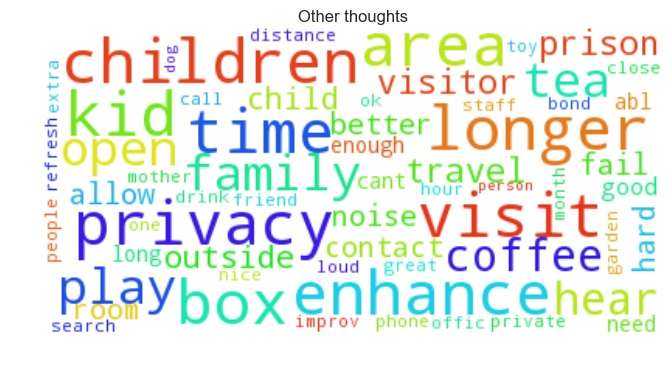

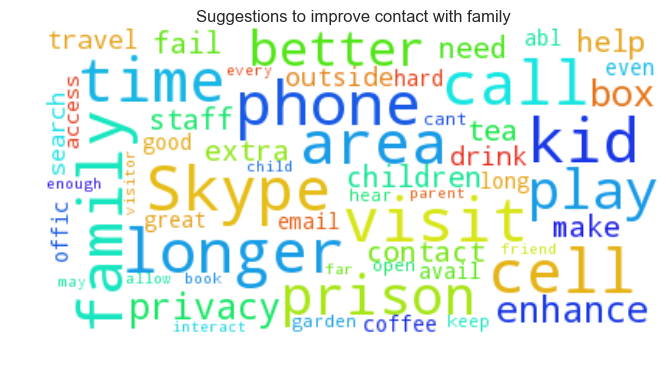

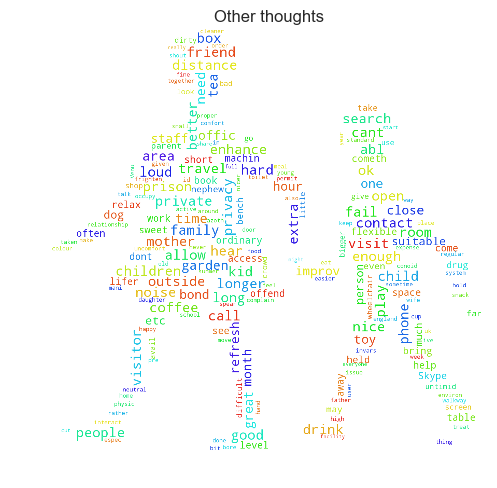

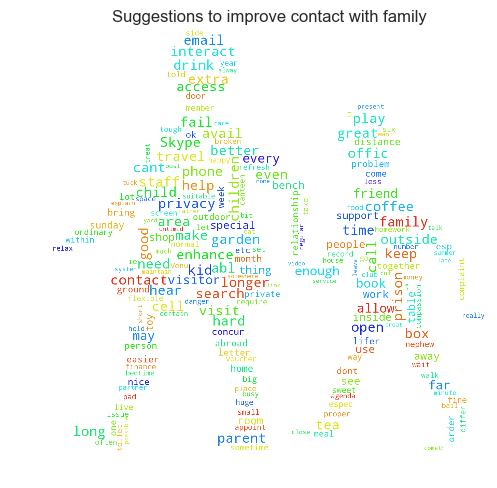

In [21]:
# now call the function to actually make the clouds - once for each combination of free text columns and options

# simple
make_wordcloud(df, 'prison_service_facilities_other_thoughts', 'Other thoughts', 'other_thoughts_no_mask.png', False)
make_wordcloud(df, 'improve_contact_family_other_suggestions', 'Suggestions to improve contact with family', 'improve_contact_suggestions_no_mask.png', False)

# with mask
make_wordcloud(df, 'prison_service_facilities_other_thoughts', 'Other thoughts', 'other_thoughts_mask.png', mask)
make_wordcloud(df, 'improve_contact_family_other_suggestions', 'Suggestions to improve contact with family', 'improve_contact_suggestions_mask.png', mask)

# bigrams
######## This needs to be redone for the new bigrams above. 
######## We were talking about doing similar to what Colm had done and join the top 10 or so with an _ and printing that. 
#make_wordcloud(df, 'prison_service_facilities_other_thoughts', 'Other thoughts (bigrams)', 'other_thoughts_bigram.png', False)
#make_wordcloud(df, 'improve_contact_family_other_suggestions', 'Suggestions to improve contact with family (bigrams)', 'improve_contact_suggestions_bigram.png', False)


List of negative and positive words are obtained from 
http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

In [17]:
neg_words = pd.read_csv('negative-words.txt', skiprows = 36, header = None, encoding = 'ISO-8859-1')
pos_words = pd.read_csv('positive-words.txt', skiprows = 36, header = None, encoding = 'ISO-8859-1')

In [18]:
#simply checks if the word is in the positive or negative dictionary and increments counters
#set sum to true to return a single number that could be used to compare different prisons. 
def simple_neg_pos_wc(df, column_name, sum = False):
    neg_words = pd.read_csv('negative-words.txt', skiprows = 36, header = None, encoding = 'ISO-8859-1')
    pos_words = pd.read_csv('positive-words.txt', skiprows = 36, header = None, encoding = 'ISO-8859-1')
    stop_words = set(stopwords.words('english'))  # these are nonsense words that don't belong in the wordcloud ('a','the' etc.)
    stemmer = SnowballStemmer("english")# this stemmer will clip the end of words so that begins and begin etc. look the same
    
    stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # add some characters to the stopwords
    
    # for every entry in the column, get the list of words and stem them. remove stop words
    word_list = [stemmer.stem(i.lower()) for i in wordpunct_tokenize(" ".join(df[column_name].dropna())) if i.lower() not in stop_words]
    
    # correct any spelling mistakes introduced by the stemmer
    word_list = [spell(i) for i in word_list]
    pos_count = 0
    neg_count = 0
    for word in word_list:
        if (neg_words.loc[:,0] == word).sum() > 0 :
            neg_count -=1
        if (pos_words.loc[:,0] == word).sum() > 0:
            pos_count +=1
    if sum:
        return neg_count+pos_count
    else:
        return neg_count,pos_count, len(word_list)

In [19]:
simple_neg_pos_wc(df,'prison_service_facilities_other_thoughts')

(-160, 244, 2671)

In [20]:
simple_neg_pos_wc(df,'prison_service_facilities_other_thoughts', True)

84

In [21]:
simple_neg_pos_wc(df,'improve_contact_family_other_suggestions', True)

64

Instead of checking each individual word should check each free text field as a whole. This way we can get an idea of the sentiment from each person surveyed. Also way we can implement inverters; 
e.g. "Not very clean" should be a negative sentiment, but it will include "clean" in the positive count above. 

In [22]:
def neg_pos(df, column_name):
    neg_words = pd.read_csv('negative-words.txt', skiprows = 36, header = None, encoding = 'ISO-8859-1')
    pos_words = pd.read_csv('positive-words.txt', skiprows = 36, header = None, encoding = 'ISO-8859-1')
    stop_words = set(stopwords.words('english'))  # these are nonsense words 
    stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'enhanced'])
      
    new_df = df[column_name].dropna().reset_index()
    new_df['sentiment'] = 0
    for i in range(len(new_df)):
        word_list = [i.lower() for i in wordpunct_tokenize("".join(new_df['prison_service_facilities_other_thoughts'][i])) if i.lower() not in stop_words]
        for word in word_list:
            if (pos_words.loc[:,0] == word).sum() > 0:
                new_df['sentiment'][i] +=1
            if (neg_words.loc[:,0] == word).sum() > 0:
                new_df['sentiment'][i] -=1
    return new_df['sentiment'].sum()


In [23]:
neg_pos(df, 'prison_service_facilities_other_thoughts')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


43

Basic function done. Need to include inversions.  

In [28]:
def neg_pos_inv(df, column_name):
    neg_words = pd.read_csv('negative-words.txt', skiprows = 36, header = None, encoding = 'ISO-8859-1')
    pos_words = pd.read_csv('positive-words.txt', skiprows = 36, header = None, encoding = 'ISO-8859-1')
    inv_words = ['not', 'lack of', 'only', 'can\'t','no', 'more']
    #stop_words = set(stopwords.words('english'))  # these are nonsense words 
    stop_words = (['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'enhanced'])
      
    new_df = df[column_name].dropna().reset_index()
    new_df['sentiment'] = 0
    negation = False
    prev = None
    pprev = None
    for i in range(len(new_df)):
        word_list = [i.lower() for i in wordpunct_tokenize("".join(new_df['prison_service_facilities_other_thoughts'][i])) if i.lower() not in stop_words]
        for word in word_list:
            if ((pos_words.loc[:,0] == word).sum() > 0) and (prev not in inv_words):
                new_df['sentiment'][i] +=1
            if ((pos_words.loc[:,0] == word).sum() > 0) and (prev in inv_words or pprev in inv_words):
                new_df['sentiment'][i] -=1
            if (neg_words.loc[:,0] == word).sum() > 0:
                new_df['sentiment'][i] -=1
            prev = word
            ppev = prev
    return new_df['sentiment'].sum()

In [29]:
neg_pos_inv(df, 'prison_service_facilities_other_thoughts')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-39

This is relatively basic, but could give us a metric to compare sentiment between the different prisons. 